# Importing required libraries

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import math
from numpy import argmax
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import numpy as np
import time
import statistics

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [2]:
# Monte Carlo Dropout Layer
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Read in the Train and Test data

In [4]:
X_train = np.array(pd.read_parquet('data/X_train.parquet')).astype('float')
X_test = np.array(pd.read_parquet('data/X_test.parquet')).astype('float')

y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
#y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
#y_train_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
y_test_reg = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv']).astype('float')
y_train_reg = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv']).astype('float')

# Check Data before Modelling 

In [10]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Regression Shape:', y_train_reg.shape)
print('Testing Labels Regression Shape:', y_test_reg.shape)

Training Features Shape: (111791, 180)
Testing Features Shape: (27948, 180)
Training Labels Regression Shape: (111791,)
Testing Labels Regression Shape: (27948,)


# Hyperparameter Tuning

In [12]:
def model_builder(hp):
    model = keras.Sequential()

    # layer 01
    layer_01 = hp.Choice('layer_01', values = ['False','True'])
    if layer_01:
        units_01 = hp.Int('units_01', min_value=64, max_value=1024, step=32)
        activation_01 = hp.Choice('activation_01', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_01 = hp.Choice('kernel_01', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_01, activation = activation_01, kernel_initializer=kernel_initializer_01, input_shape = (X_train.shape[1],)))
    
    batch_01 = hp.Choice('batch_01', values = ['False','True'])
    if batch_01:
        model.add(BatchNormalization())
    
    drop_01 = hp.Choice('drop_01', values = ['False','drop','Monte'])
    if drop_01 == 'drop':
        dropout_01 = hp.Float('dropout_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_01))
    elif drop_01 == 'Monte':
        monte_01 = hp.Float('monte_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_01))
    
    # layer 02
    layer_02 = hp.Choice('layer_02', values = ['False','True'])
    if layer_02:
        units_02 = hp.Int('units_02', min_value = 32, max_value = 512, step=32)
        activation_02 = hp.Choice('activation_02', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_02 = hp.Choice('kernel_02', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_02, activation = activation_02, kernel_initializer=kernel_initializer_02))
    
    batch_02 = hp.Choice('batch_02', values = ['False','True'])
    if batch_02:
        model.add(BatchNormalization())
        
    drop_02 = hp.Choice('drop_02', values = ['False','drop','Monte'])
    if drop_02:
        dropout_02 = hp.Float('dropout_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_02))
    elif drop_02 == 'Monte':
        monte_02 = hp.Float('monte_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_02))
    
    # layer 03
    layer_03 = hp.Choice('layer_03', values = ['False','True'])
    if layer_03:
        units_03 = hp.Int('units_03', min_value = 32, max_value = 512, step=32)
        activation_03 = hp.Choice('activation_03', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_03 = hp.Choice('kernel_03', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_03, activation = activation_03, kernel_initializer=kernel_initializer_03))
    
    drop_03 = hp.Choice('drop_03', values = ['False','drop','Monte'])
    if drop_03:
        dropout_03 = hp.Float('dropout_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_03))
    elif drop_03 == 'Monte':
        monte_03 = hp.Float('monte_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_03))
    
    batch_03 = hp.Choice('batch_03', values = ['False','True'])
    if batch_03:
        model.add(BatchNormalization())
    
    # layer 04
    layer_04 = hp.Choice('layer_04', values = ['False','True'])
    if layer_04:
        units_04 = hp.Int('units_04', min_value = 16, max_value = 512, step=32)
        activation_04 = hp.Choice('activation_04', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_04 = hp.Choice('kernel_04', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_04, activation = activation_04, kernel_initializer=kernel_initializer_04))
    
    drop_04 = hp.Choice('drop_04', values = ['False','drop','Monte'])
    if drop_04:
        dropout_04 = hp.Float('dropout_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_04))
    elif drop_04 == 'Monte':
        monte_04 = hp.Float('monte_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_04))
        
    batch_04 = hp.Choice('batch_04', values = ['False','True'])
    if batch_04:
        model.add(BatchNormalization())
    
    # layer 05
    layer_05 = hp.Choice('layer_05', values = ['False','True'])
    if layer_05:
        units_05 = hp.Int('units_05', min_value = 16, max_value = 256, step=32)
        activation_05 = hp.Choice('activation_05', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_05 = hp.Choice('kernel_05', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_05, activation = activation_05, kernel_initializer=kernel_initializer_05))
    
    drop_05 = hp.Choice('drop_05', values = ['False','drop','Monte'])
    if drop_05:
        dropout_05 = hp.Float('dropout_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_05))
    elif drop_05 == 'Monte':
        monte_05 = hp.Float('monte_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_05))
        
    batch_05 = hp.Choice('batch_05', values = ['False','True'])
    if batch_05:
        model.add(BatchNormalization())
    
    # layer 06
    layer_06 = hp.Choice('layer_06', values = ['False','True'])
    if layer_06:
        units_06 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_06 = hp.Choice('activation_06', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_06 = hp.Choice('kernel_06', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_06, activation = activation_06, kernel_initializer=kernel_initializer_06))
        
    # layer 07
    layer_07 = hp.Choice('layer_07', values = ['False','True'])
    if layer_07:
        units_07 = hp.Int('units_07', min_value = 4, max_value = 16, step=4)
        activation_07 = hp.Choice('activation_07', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_07 = hp.Choice('kernel_07', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_07, activation = activation_07, kernel_initializer=kernel_initializer_07))    
    
    # layer 08
    layer_08 = hp.Choice('layer_08', values = ['False','True'])
    if layer_08:
        units_08 = hp.Int('units_08', min_value = 4, max_value = 16, step=4)
        activation_08 = hp.Choice('activation_08', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_08 = hp.Choice('kernel_08', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_08, activation = activation_08, kernel_initializer=kernel_initializer_08))
        
    # layer 09
    layer_09 = hp.Choice('layer_06', values = ['False','True'])
    if layer_09:
        units_09 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_09 = hp.Choice('activation_09', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_09 = hp.Choice('kernel_09', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_09, activation = activation_09, kernel_initializer=kernel_initializer_09))
        
    # layer 10
    layer_10 = hp.Choice('layer_10', values = ['False','True'])
    if layer_10:
        units_10 = hp.Int('units_10', min_value = 4, max_value = 16, step=4)
        activation_10 = hp.Choice('activation_10', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_10 = hp.Choice('kernel_10', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_10, activation = activation_10, kernel_initializer=kernel_initializer_10))
    
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mse', metrics = ['mse', 'mae',rmse,'mape','msle'])

    return model

In [13]:
# Select Tuner Hyperband
tuner = kt.Hyperband(model_builder,
                     objective = 'mse',
                     max_epochs = 40,
                     factor = 6,
                     project_name = 'MLP_Regression_02')

stop_early = callbacks.EarlyStopping(monitor='loss', patience=7)

INFO:tensorflow:Reloading Oracle from existing project ./MLP_Regression_02/oracle.json
INFO:tensorflow:Reloading Tuner from ./MLP_Regression_02/tuner0.json


In [14]:
tuner.search(X_train, y_train_reg, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal model is:')
print(best_hps)

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal model is:


In [15]:
tuner.results_summary()

Results summary
Results in ./MLP_Regression_02
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
layer_01: False
units_01: 992
activation_01: tanh
kernel_01: he_uniform
batch_01: False
drop_01: drop
layer_02: True
units_02: 128
activation_02: LeakyReLU
kernel_02: he_uniform
batch_02: True
drop_02: drop
dropout_02: 0.4
layer_03: True
units_03: 256
activation_03: sigmoid
kernel_03: glorot_normal
drop_03: drop
dropout_03: 0.30000000000000004
batch_03: False
layer_04: False
units_04: 240
activation_04: relu
kernel_04: glorot_normal
drop_04: False
dropout_04: 0.6
batch_04: False
layer_05: False
units_05: 144
activation_05: relu
kernel_05: glorot_uniform
drop_05: False
dropout_05: 0.6
batch_05: True
layer_06: True
units_06: 12
activation_06: relu
kernel_06: glorot_normal
layer_07: True
units_07: 8
activation_07: tanh
kernel_07: glorot_normal
layer_08: False
units_08: 4
activation_08: sigmoid
kernel_08: he_normal
activation_09: relu
kernel_09: he_uni

In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_reg,validation_split=0.33, epochs = 100)

Epoch 1/100
2341/2341 [==============================] - 15s 6ms/step - loss: 1242.7747 - mse: 1242.7747 - mae: 19.0526 - rmse: 19.0526 - mape: 217.9375 - msle: 1.3874 - val_loss: 834.1099 - val_mse: 834.1099 - val_mae: 15.8695 - val_rmse: 15.8695 - val_mape: 169.2435 - val_msle: 0.8042
Epoch 2/100
2341/2341 [==============================] - 13s 6ms/step - loss: 842.4205 - mse: 842.4205 - mae: 16.4145 - rmse: 16.4145 - mape: 208.6411 - msle: 0.9447 - val_loss: 774.5073 - val_mse: 774.5073 - val_mae: 14.8517 - val_rmse: 14.8517 - val_mape: 168.1959 - val_msle: 0.7742
Epoch 3/100
2341/2341 [==============================] - 12s 5ms/step - loss: 808.0950 - mse: 808.0950 - mae: 15.9191 - rmse: 15.9191 - mape: 206.6107 - msle: 0.9318 - val_loss: 774.9964 - val_mse: 774.9964 - val_mae: 14.1017 - val_rmse: 14.1017 - val_mape: 143.4581 - val_msle: 0.6960
Epoch 4/100
2341/2341 [==============================] - 12s 5ms/step - loss: 788.8129 - mse: 788.8129 - mae: 15.6083 - rmse: 15.6083 - mape

Epoch 30/100
2341/2341 [==============================] - 13s 5ms/step - loss: 669.3128 - mse: 669.3128 - mae: 14.0786 - rmse: 14.0786 - mape: 175.9208 - msle: 0.7929 - val_loss: 761.0150 - val_mse: 761.0150 - val_mae: 14.8008 - val_rmse: 14.8008 - val_mape: 178.3624 - val_msle: 0.8096
Epoch 31/100
2341/2341 [==============================] - 12s 5ms/step - loss: 665.5091 - mse: 665.5091 - mae: 14.0207 - rmse: 14.0207 - mape: 174.1432 - msle: 0.7858 - val_loss: 773.4484 - val_mse: 773.4484 - val_mae: 15.9150 - val_rmse: 15.9150 - val_mape: 210.2553 - val_msle: 0.9251
Epoch 32/100
2341/2341 [==============================] - 12s 5ms/step - loss: 661.4587 - mse: 661.4587 - mae: 13.9543 - rmse: 13.9543 - mape: 172.5792 - msle: 0.7793 - val_loss: 770.5809 - val_mse: 770.5809 - val_mae: 14.3742 - val_rmse: 14.3742 - val_mape: 149.5356 - val_msle: 0.7179
Epoch 33/100
2341/2341 [==============================] - 12s 5ms/step - loss: 654.3251 - mse: 654.3251 - mae: 13.8655 - rmse: 13.8655 - ma

2341/2341 [==============================] - 13s 6ms/step - loss: 576.0621 - mse: 576.0621 - mae: 12.9048 - rmse: 12.9048 - mape: 165.9698 - msle: 0.7370 - val_loss: 824.8785 - val_mse: 824.8785 - val_mae: 14.8340 - val_rmse: 14.8340 - val_mape: 175.0437 - val_msle: 0.7945
Epoch 59/100
2341/2341 [==============================] - 14s 6ms/step - loss: 570.8686 - mse: 570.8686 - mae: 12.8861 - rmse: 12.8861 - mape: 164.7974 - msle: 0.7364 - val_loss: 829.5825 - val_mse: 829.5825 - val_mae: 14.2714 - val_rmse: 14.2714 - val_mape: 147.8567 - val_msle: 0.7092
Epoch 60/100
2341/2341 [==============================] - 12s 5ms/step - loss: 562.1868 - mse: 562.1868 - mae: 12.7576 - rmse: 12.7576 - mape: 165.1186 - msle: 0.7357 - val_loss: 824.5981 - val_mse: 824.5981 - val_mae: 14.5540 - val_rmse: 14.5540 - val_mape: 161.3610 - val_msle: 0.7546
Epoch 61/100
2341/2341 [==============================] - 14s 6ms/step - loss: 566.0161 - mse: 566.0161 - mae: 12.8105 - rmse: 12.8105 - mape: 164.6479 

Epoch 87/100
2341/2341 [==============================] - 14s 6ms/step - loss: 502.2345 - mse: 502.2345 - mae: 12.0523 - rmse: 12.0523 - mape: 160.8423 - msle: 0.7059 - val_loss: 885.7739 - val_mse: 885.7739 - val_mae: 14.9404 - val_rmse: 14.9404 - val_mape: 170.8519 - val_msle: 0.7811
Epoch 88/100
2341/2341 [==============================] - 13s 6ms/step - loss: 504.3044 - mse: 504.3044 - mae: 12.0607 - rmse: 12.0607 - mape: 159.8439 - msle: 0.7028 - val_loss: 895.9698 - val_mse: 895.9698 - val_mae: 14.6057 - val_rmse: 14.6057 - val_mape: 156.8806 - val_msle: 0.7459
Epoch 89/100
2341/2341 [==============================] - 13s 5ms/step - loss: 505.7724 - mse: 505.7724 - mae: 12.0694 - rmse: 12.0694 - mape: 158.6469 - msle: 0.7001 - val_loss: 873.7540 - val_mse: 873.7540 - val_mae: 14.1186 - val_rmse: 14.1186 - val_mape: 144.8058 - val_msle: 0.7118
Epoch 90/100
2341/2341 [==============================] - 13s 6ms/step - loss: 498.5004 - mse: 498.5004 - mae: 11.9809 - rmse: 11.9809 - ma

In [17]:
val_loss_per_epoch = history.history['val_mse']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 10


In [18]:
start_time = time.time()
hypermodel = tuner.hypermodel.build(best_hps)
print(str(model),"--- %s seconds ---" % ((time.time() - start_time)))

# Retrain the model
history = hypermodel.fit(X_train, y_train_reg,validation_split=0.33, epochs=best_epoch)

<keras.engine.sequential.Sequential object at 0x7fd5015da7f0> --- 0.13338780403137207 seconds ---
Epoch 1/10
2341/2341 [==============================] - 15s 6ms/step - loss: 1301.3192 - mse: 1301.3192 - mae: 19.3221 - rmse: 19.3221 - mape: 217.7693 - msle: 1.3792 - val_loss: 827.9112 - val_mse: 827.9112 - val_mae: 16.7793 - val_rmse: 16.7793 - val_mape: 225.5882 - val_msle: 0.9849
Epoch 2/10
2341/2341 [==============================] - 14s 6ms/step - loss: 857.9935 - mse: 857.9935 - mae: 16.6427 - rmse: 16.6427 - mape: 213.4611 - msle: 0.9628 - val_loss: 794.3454 - val_mse: 794.3454 - val_mae: 15.1667 - val_rmse: 15.1667 - val_mape: 201.8251 - val_msle: 0.8923
Epoch 3/10
2341/2341 [==============================] - 15s 6ms/step - loss: 822.2403 - mse: 822.2403 - mae: 16.1186 - rmse: 16.1186 - mape: 202.8827 - msle: 0.9210 - val_loss: 774.7701 - val_mse: 774.7701 - val_mae: 14.8281 - val_rmse: 14.8281 - val_mape: 172.2880 - val_msle: 0.7931
Epoch 4/10
2341/2341 [=======================

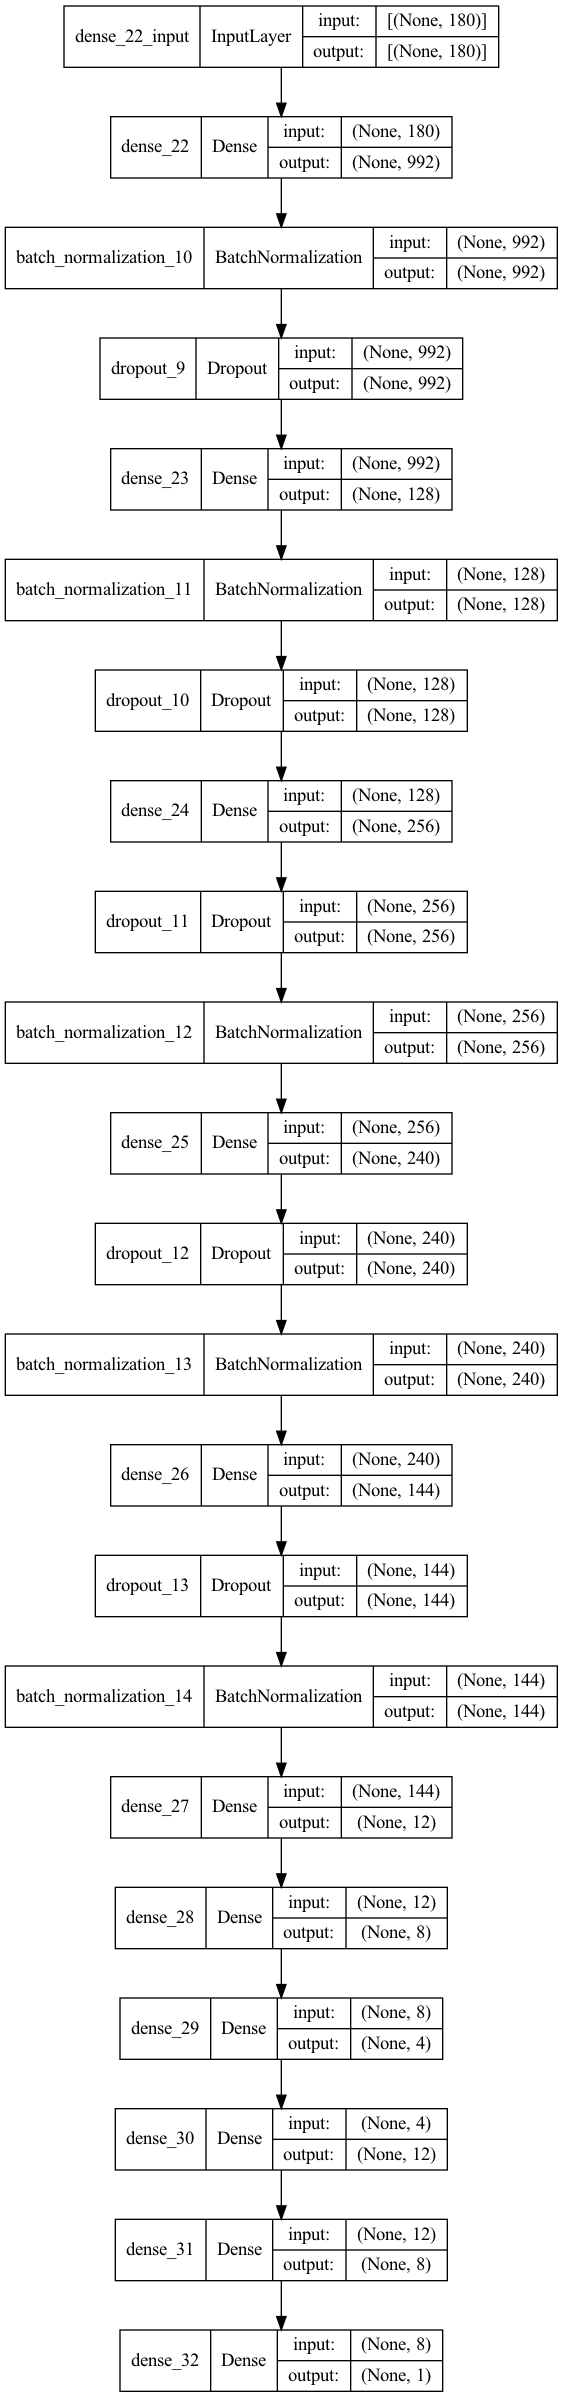

In [19]:
# Print Model Layout:
plot_model(hypermodel, to_file='hypermodel_reg.png', show_shapes=True)

In [20]:
eval_result = hypermodel.evaluate(X_test, y_test_reg)
print("[loss, MSE, MAE, RMSE, MAPE, MSLE]:", eval_result)

874/874 [==============================] - 1s 2ms/step - loss: 755.7313 - mse: 755.7313 - mae: 14.7645 - rmse: 14.7645 - mape: 161.7095 - msle: 0.7709
[loss, MSE, MAE, RMSE, MAPE, MSLE]: [755.7312622070312, 755.7312622070312, 14.764543533325195, 14.764543533325195, 161.7095489501953, 0.7709115147590637]


# 10-Fold Cross-Validation

In [21]:
# Define the K-fold Cross Validator

if cross_validation:

    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    loss_per_fold = []
    MAE_per_fold = []

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train_reg, y_test_reg), axis=0)

    for train, test in kfold.split(inputs, targets):

        best_model = tuner.hypermodel.build(best_hps)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        best_model.fit(inputs[train], targets[train], epochs=best_epoch, verbose=0, callbacks = [stop_early])
        score = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {score}')

        yhat = model.predict(inputs[test])
        print('MAE: %.3f' % mean_absolute_error(targets[test], yhat))

        MAE_per_fold.append(mean_absolute_error(targets[test], yhat))
        loss_per_fold.append(score)

        # Increase fold number
        fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: [611.728759765625, 611.728759765625, 12.31832218170166, 12.31832218170166, 151.6319580078125, 0.6750420331954956]
MAE: 12.318
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: [611.722412109375, 611.722412109375, 12.195608139038086, 12.195608139038086, 155.62860107421875, 0.6816855669021606]
MAE: 12.196
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: [633.5791015625, 633.5791015625, 12.459059715270996, 12.45905876159668, 153.9893035888672, 0.6861191987991333]
MAE: 12.459
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: [587.80419921875, 587.80419921875, 12.157733917236328, 12.157733917236328, 152.07540893554688, 0.6660560965538025]
MAE: 12.158
-----------------------------------

In [22]:
loss = []
mse = []
mae = []
rmse = []
mape = []
msle = []
for i in range(len(loss_per_fold)):
    loss.append(loss_per_fold[i][0])
    mse.append(loss_per_fold[i][1])
    mae.append(loss_per_fold[i][2])
    rmse.append(loss_per_fold[i][3])
    mape.append(loss_per_fold[i][4])
    msle.append(loss_per_fold[i][5])

In [23]:
print("Mean Loss: %s" % statistics.mean(loss))
print("Mean MSE: %s" % statistics.mean(mse))
print("Mean MAE: %s" % statistics.mean(mae))
print("Mean RMSE: %s" % statistics.mean(rmse))
print("Mean MAPE: %s" % statistics.mean(mape))
print("Mean MSLE: %s" % statistics.mean(msle))

Mean Loss: 614.3280090332031
Mean MSE: 614.3280090332031
Mean MAE: 12.285917282104492
Mean RMSE: 12.285916900634765
Mean MAPE: 152.9303207397461
Mean MSLE: 0.6785399138927459


In [31]:
print("SD Loss: %s" % statistics.stdev(loss))
print("SD MSE: %s" % statistics.stdev(mse))
print("SD MAE: %s" % statistics.stdev(mae))
print("SD RMSE: %s" % statistics.stdev(rmse))
print("SD MAPE: %s" % statistics.stdev(mape))
print("SD MSLE: %s" % statistics.stdev(msle))

SD Loss: 12.810356645439425
SD MSE: 12.810356645439425
SD MAE: 0.09835815502428714
SD RMSE: 0.09835794800668245
SD MAPE: 1.8637765505447297
SD MSLE: 0.006118258364568258


# Plot Results

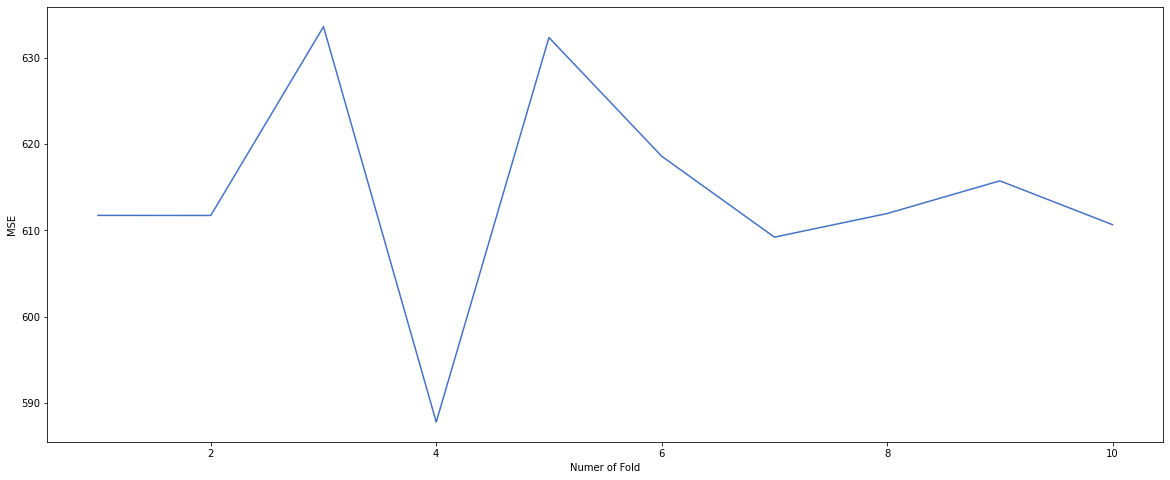

In [24]:
plt.figure(figsize=(20, 8))
#Create the plots
plt.plot(range(1,len(loss)+1),loss, color = '#4472C4', label = 'MSE')
#plt.plot(range(1,len(mape)+1),mape, color='red', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MSE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MSE.png')
plt.rcParams.update({'font.size': 12})

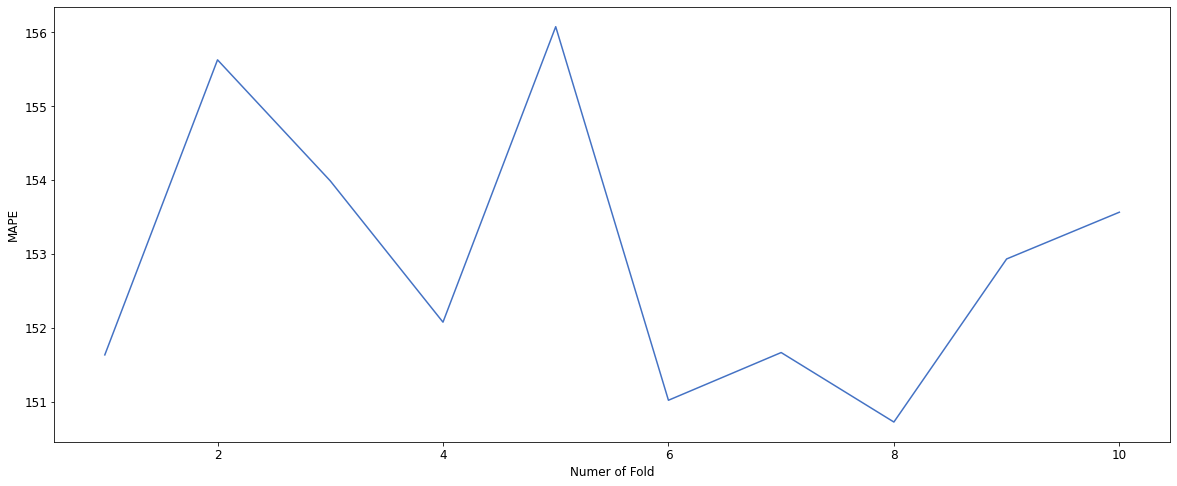

In [25]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(loss)+1),loss, color='blue', label = 'MSE')
plt.plot(range(1,len(mape)+1),mape, color = '#4472C4', label = 'MAPE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MAPE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MAPE.png')
plt.rcParams.update({'font.size': 12})

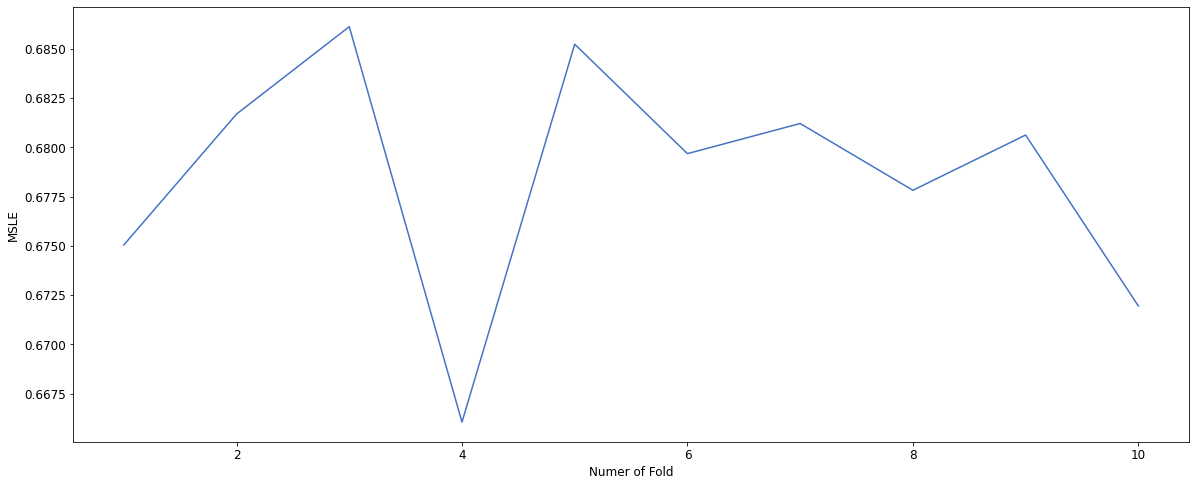

In [33]:
plt.figure(figsize=(20, 8))
#Create the plots
#plt.plot(range(1,len(MAE_per_fold)+1),MAE_per_fold, color='blue', label = 'MAE')
plt.plot(range(1,len(msle)+1),msle, color = '#4472C4', label = 'MSLE')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('MSLE')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_MSLE.png')
plt.rcParams.update({'font.size': 12})